## Exploratory Data Analysis
In this part, we aim to analyse data points available from our RawData that are strong predictors for whether a user interaction with a product will result in a cart (and possibly purchase) rather than remaining as a view item.


In [1]:
# 0. Basic Libraries importation
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from datetime import datetime

In [2]:
#Import cleaned data as a panda dataframe for analysis
df = pd.read_csv('CartPurchaseData.csv.gz', compression = 'gzip', index_col=False)

In [3]:
#Print total number of rows of data
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544820 entries, 0 to 3544819
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   event_time          3544820 non-null  object 
 1   event_type          3544820 non-null  int64  
 2   product_id          3544820 non-null  int64  
 3   category_id         3544820 non-null  int64  
 4   category_code       3544820 non-null  object 
 5   brand               3544820 non-null  object 
 6   price               3544820 non-null  float64
 7   user_id             3544820 non-null  int64  
 8   user_session        3544785 non-null  object 
 9   activity_count      3544785 non-null  float64
 10  user_session_count  3544820 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 297.5+ MB


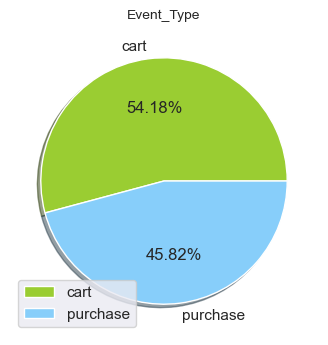

In [4]:
# Preliminary visualization to see proportion of events that are actually turn into a purchase from a cart event
labels = ['cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue']

plt.rcParams['figure.figsize'] = (4, 4)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 10)
plt.axis('off')
plt.legend()
plt.show()

This diagram shows that around 45.82% of all items added to cart becomes a purchase. However, 54.18% of items remain in cart and never purchased.In this model, we seek to understand the key predictors that will affect whether a cart item will become a purchase.

### Determine Predictors
We aim to use the key data points in the our data as predictor for the event type.\
In this model, we are trying to build a model for predicting whether an item in cart will remain in cart (event_type == 1) or be purchased eventually (event_type == 2).\
\
Based on our common sense and some logical deduction, we hypothesize that the key predictors that we need that are available or derivable from the data are:

1. Category of the product
2. Sub-category of the product (since this information is provided in our dataset).
3. Weekday: weekday of the event
4. Day of month: Date of event
5. Time period of the event: Morning (6am -2pm), Afternoon(2pm - 10pm) and Night(10pm - 6am)
6. User access history: Number of sessions accessed by user before this event. This show customer's loyalty or familiarity with the online shop.
7. Activity count: Number of activities user engage in in one session.
8. Brand of product
9. Price of product 

We will now examine all these 9 data points to see if they are good predictors for event type through data analysis and visualization methods.

#### A. Product Category and Sub-category

In [5]:
#Split the category code into product category and sub-category
df['product_category'] =df['category_code'].str.split(".",expand=True)[0].astype('category')
df['product_sub_category'] = df['category_code'].str.split(".",expand=True)[1].astype('category')
#Remove column category_code from dataframe to save memory
del df['category_code']
df.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,activity_count,user_session_count,product_category,product_sub_category
0,2019-12-05 14:47:30+00:00,1,1005100,2232732093077520756,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,construction,tools
1,2020-01-26 03:11:20+00:00,1,1005266,2232732093077520756,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,construction,tools
2,2020-01-24 07:13:03+00:00,1,1201567,2232732101407408685,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,apparel,shoes
3,2019-12-04 03:00:48+00:00,1,1701392,2053013553031414015,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,computers,peripherals
4,2020-01-16 08:58:58+00:00,1,1005203,2232732093077520756,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,construction,tools


In [6]:
# Understand the product category variable
df['product_category'].unique()

['construction', 'apparel', 'computers', 'sport', 'electronics', ..., 'country_yard', 'kids', 'stationery', 'auto', 'medicine']
Length: 13
Categories (13, object): ['accessories', 'apparel', 'appliances', 'auto', ..., 'kids', 'medicine', 'sport', 'stationery']

In [7]:
# Understand the product sub-category variable
print(list(df['product_sub_category'].unique()))

['tools', 'shoes', 'peripherals', 'bicycle', 'audio', 'living_room', 'personal', 'clocks', 'bag', 'camera', 'kitchen', 'environment', 'cultivator', 'trainer', 'notebook', 'swing', 'trousers', 'desktop', 'cartrige', 'accessories', 'video', 'tablet', 'smartphone', 'bedroom', 'ironing_board', 'components', 'scarf', 'pajamas', 'universal', 'fmcg', 'toys', 'jumper', 'ski', 'costume', 'shorts', 'skates', 'ebooks', 'tshirt', 'shirt', 'sock', 'sewing_machine', 'glove', 'bathroom', 'underwear', 'wallet', 'jeans', 'dolls', 'telephone', 'furniture', 'carriage', 'belt', 'iron', 'diving', 'lawn_mower', 'umbrella', 'tennis', 'snowboard', 'dress', 'jacket', 'skirt']


In [8]:
#Split dataframe into Cart data event and Purchase data event for easy visualization
CartData = df.loc[df['event_type'] == 1]
PurchaseData = df.loc[df['event_type'] == 2]

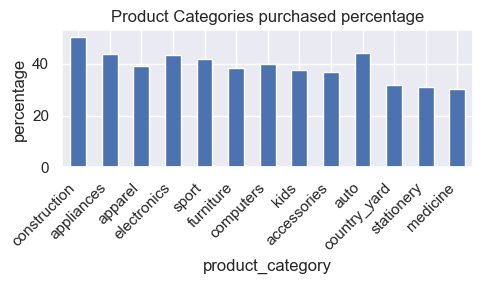

product_category
construction    1685210
appliances       584505
apparel          354802
electronics      310264
sport            257122
furniture        131643
computers        101590
kids              61542
accessories       27868
auto              20798
country_yard       6727
stationery         2099
medicine            650
Name: count, dtype: int64

In [9]:
plt.figure(figsize=(5, 3))
percentagePurchased = 100* PurchaseData['product_category'].value_counts()/df['product_category'].value_counts()
percentagePurchased.plot(kind='bar')
plt.ylabel('percentage')
plt.title('Product Categories purchased percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

df['product_category'].value_counts()

Interestingly, from the bar chart, we can see that there is no significant difference in the cart to purchase ratio for each product category. \
They are all around a 55-45 split, especially among the top product categories, which corresponds to the split in the number of events. We observe a 70-30 split in the last 3 product category. However, this error can be attributed to the lower sample size as there are fewer users who put these items to their cart to begin with. \
All in all, this suggests that product category and by extension, product sub-category **may not be a good predictor of a purchase of items in cart** as it is equally likely for a product from any category in the cart to be purchased as they are to be left in cart.

In [10]:
#Manage memory by deleting unnecessary variables and remove them from our dataframe
del PurchaseData
del CartData
del df['product_category']
del df['product_sub_category']
del df['category_id']

#### B. Time period, Day of week and Day of Month (Time of event variable)

In [12]:
def extract_time(timestamp):
    # Convert the timestamp string to a datetime object
    dt_object = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S%z")

    # Extract date of the month
    date_of_month = dt_object.day

    # Extract day of the week (Monday to Sunday: 0 to 6)
    day_of_week = dt_object.weekday()  # Monday is 0, Sunday is 6

    # Extract period of the day
    hour = dt_object.hour
    if 6 <= hour < 12:
        period_of_day = "morning"
    elif 12 <= hour < 18:
        period_of_day = "afternoon"
    else:
        period_of_day = "night"
    
    return date_of_month, day_of_week, period_of_day

In [13]:
#Add day of the week as a numerical data, day of the month and time period of the day to adjust for time data.
df[['date','weekday','time_period']] = df['event_time'].apply(extract_time).apply(pd.Series)

In [14]:
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday,time_period
0,2019-12-05 14:47:30+00:00,1,1005100,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3,afternoon
1,2020-01-26 03:11:20+00:00,1,1005266,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6,night
2,2020-01-24 07:13:03+00:00,1,1201567,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4,morning
3,2019-12-04 03:00:48+00:00,1,1701392,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2,night
4,2020-01-16 08:58:58+00:00,1,1005203,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3,morning


In [15]:
#Split dataframe into Cart data event and Purchase data event for easy visualization
CartData = df.loc[df['event_type'] == 1]
PurchaseData = df.loc[df['event_type'] == 2]

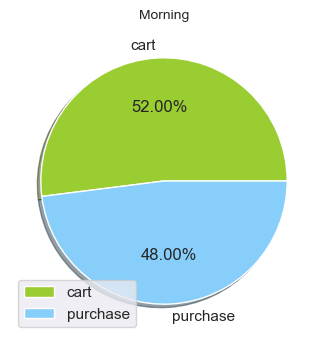

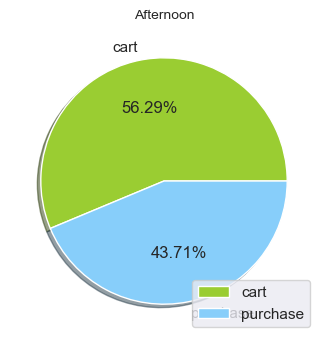

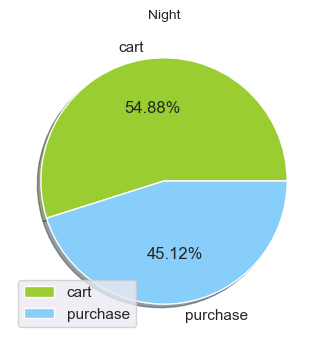

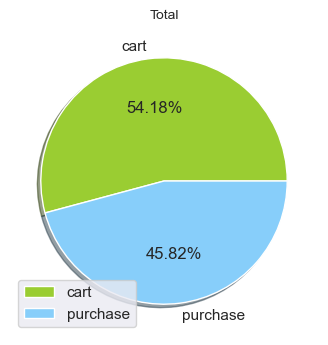

In [16]:
labels = ['cart','purchase']
size =[CartData['time_period'].value_counts().get('morning'), PurchaseData['time_period'].value_counts().get('morning')]
colors = ['yellowgreen', 'lightskyblue']
plt.rcParams['figure.figsize'] = (4, 4)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Morning', fontsize = 10)
plt.axis('off')
plt.legend()
plt.show()

labels = ['cart','purchase']
size =[CartData['time_period'].value_counts().get('afternoon'), PurchaseData['time_period'].value_counts().get('afternoon')]
colors = ['yellowgreen', 'lightskyblue']
plt.rcParams['figure.figsize'] = (4, 4)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Afternoon', fontsize = 10)
plt.axis('off')
plt.legend()
plt.show()

labels = ['cart','purchase']
size =[CartData['time_period'].value_counts().get('night'), PurchaseData['time_period'].value_counts().get('night')]
colors = ['yellowgreen', 'lightskyblue']
plt.rcParams['figure.figsize'] = (4, 4)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Night', fontsize = 10)
plt.axis('off')
plt.legend()
plt.show()

labels = ['cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue']

plt.rcParams['figure.figsize'] = (4, 4)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Total', fontsize = 10)
plt.axis('off')
plt.legend()
plt.show()

Again, differences in distribution in different time period as compared to the overall distribution of events is negligible in (at most a **2.2% difference**). This means that it is also **hard to use time period as a predictor** for whether a cart item is purchased or not.

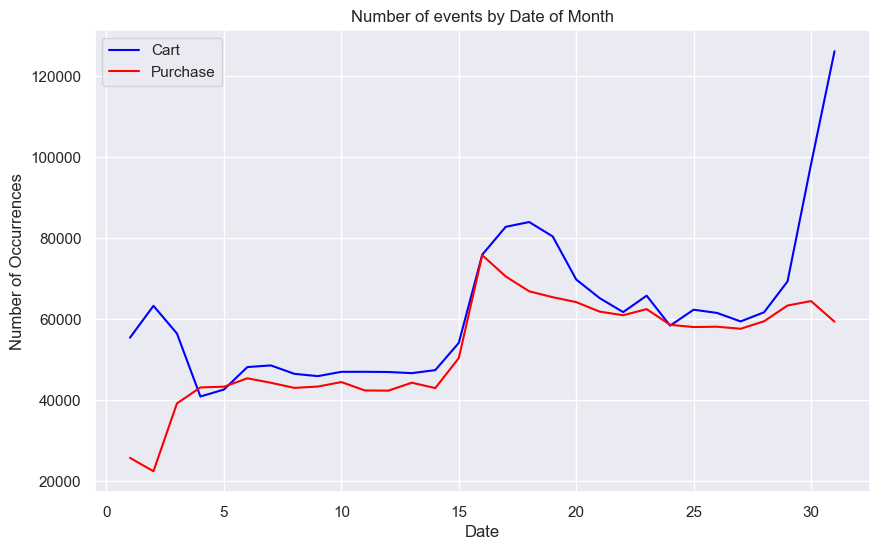

In [17]:
date_counts_cart = CartData.groupby('date').size()
date_counts_purchase= PurchaseData.groupby('date').size()

# Plot the time series for each dataframe
date_counts_cart.plot(kind='line', figsize=(10, 6), color='blue', label='Cart')
date_counts_purchase.plot(kind='line', figsize=(10, 6), color='red', label='Purchase')


plt.title('Number of events by Date of Month')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.grid(True)
plt.show()

Interestingly, items that are carted at the beginning and end periods of each month (specifically on the **1st, 2nd, 30th and 31st of each month**) appears to have signigicant differences in Cart and Purchase data. Keeping in mind that these data are only from the 2 months December and January, this may suggests that people maynot want to buy things during this period despite scrolling and adding items to cart due to promotions because they are able to think through their decisions. **Date of month can be used as a predictor for potential purchase.**

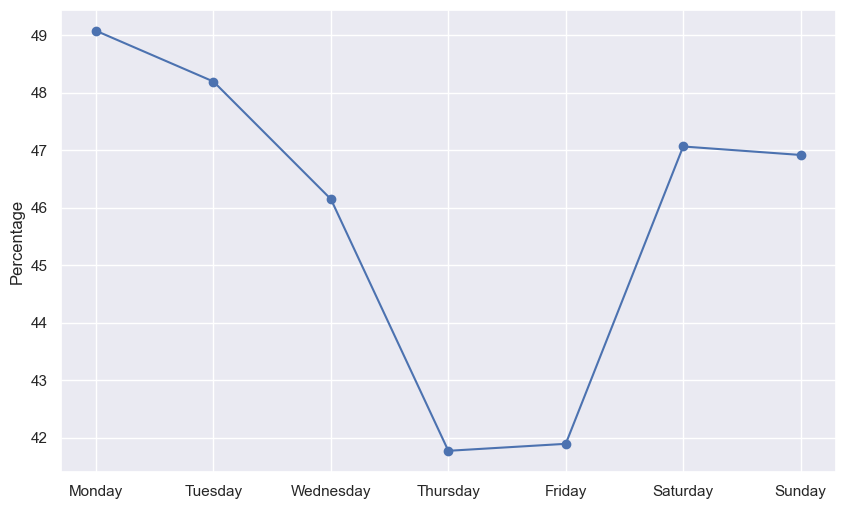

In [18]:
day_percentage_purchase= 100 * PurchaseData.groupby('weekday').size() / df.groupby('weekday').size()

# Plot the time series for each dataframe
plt.figure(figsize=(10, 6))
plt.plot(day_percentage_purchase.index, day_percentage_purchase.values, marker='o', linestyle='-')
plt.ylabel('Percentage')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

It appears that items that are added to cart at the beggining and end of the week (Monday and Sunday) are more likely to get purchased (>45% of them are carted items are purchased while items carted on Thursday and Friday are less likely to be purchased (~42%). Hence,**day of the week is a good predictor** for whether a carted item is purchased. (maximum difference is ~8% between Monday and Thursday, which is significant)

In [19]:
#Manage memory by deleting variables that will not be used.
del PurchaseData
del CartData
del df['time_period']
del date_counts_purchase
del date_counts_cart
del day_percentage_purchase
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


#### C. Activity Count (Session activities) and User Session Count (User history)

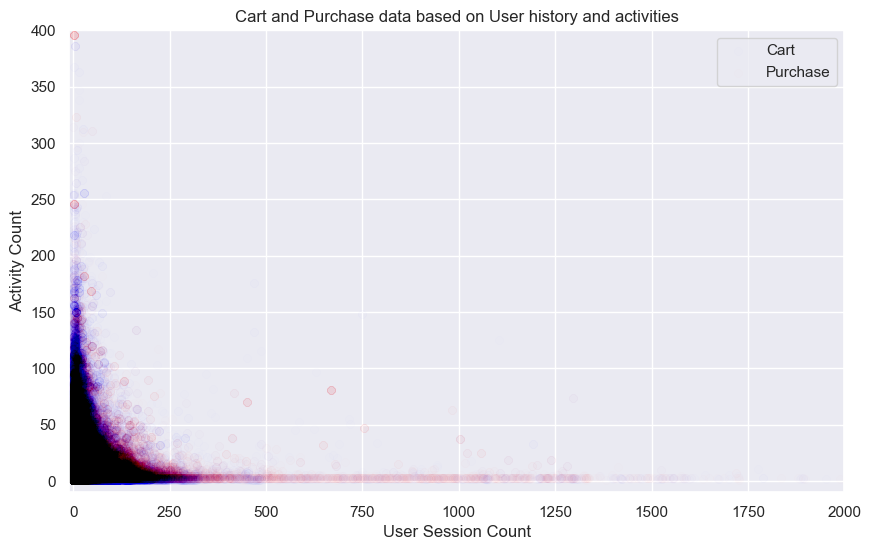

In [20]:
plt.figure(figsize=(10, 6))

# Scatter plot for event_type 1
plt.scatter(df[df['event_type'] == 1]['user_session_count'], df[df['event_type'] == 1]['activity_count'],
            color='blue', alpha=0.002, label='Cart')

# Scatter plot for event_type 2
plt.scatter(df[df['event_type'] == 2]['user_session_count'], df[df['event_type'] == 2]['activity_count'],
            color='red', alpha=0.002, label='Purchase')

# Adding labels and title
plt.xlabel('User Session Count')
plt.ylabel('Activity Count')
plt.title('Cart and Purchase data based on User history and activities')
plt.xlim(-10, 2000)  # Limiting x-axis from 0 to 10
plt.ylim(-10, 400)  # Limiting y-axis from 0 to 1000
# Adding legend
plt.legend()

plt.grid(True)
plt.show()


While it is hard to discern, the scatter plot seems to suggests a positive correlation between user_session_count and purchase probability ie. the more familiar the user is with the platform the current session, the more likely that they will buy a product.\
However, there seems to be a negative correlation between activity_count and purchase ie. the more actions performed in one session, the less likely that a purchase is made.\
These relationships are illustrated by two tails of colors extending to the extreme. On the plot, the tail in the increasing activity count direction is blue (representing items remained in cart) and the tail in the increasing user_session_count direction is mostly red (representing items purchased). However, the middle portion that contains bulk of the data - represent regular customers who spend little to moderate amount of time on the platform while not yet familiart with it) has a rougly equal split in purchases and remain in cart.\
All in all, we still consider both variables :**activity_count** and **user_session_count** as **adequate predictors** for whether a purchase will occur to items in cart.

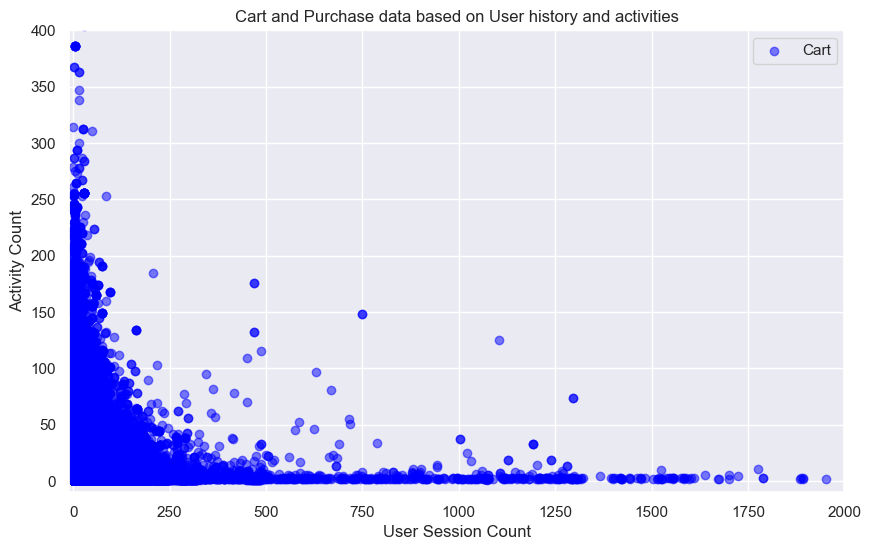

In [21]:
#Supplementary: Individual Scatter Plot
plt.figure(figsize=(10, 6))

# Scatter plot for cart
plt.scatter(df[df['event_type'] == 1]['user_session_count'], df[df['event_type'] == 1]['activity_count'],
            color='blue', alpha=0.5, label='Cart')

# Adding labels and title
plt.xlabel('User Session Count')
plt.ylabel('Activity Count')
plt.title('Cart and Purchase data based on User history and activities')

plt.xlim(-10, 2000)  # Limiting x-axis from 0 to 10
plt.ylim(-10, 400)  # Limiting y-axis from 0 to 1000
# Adding legend
plt.legend()

plt.grid(True)
plt.show()

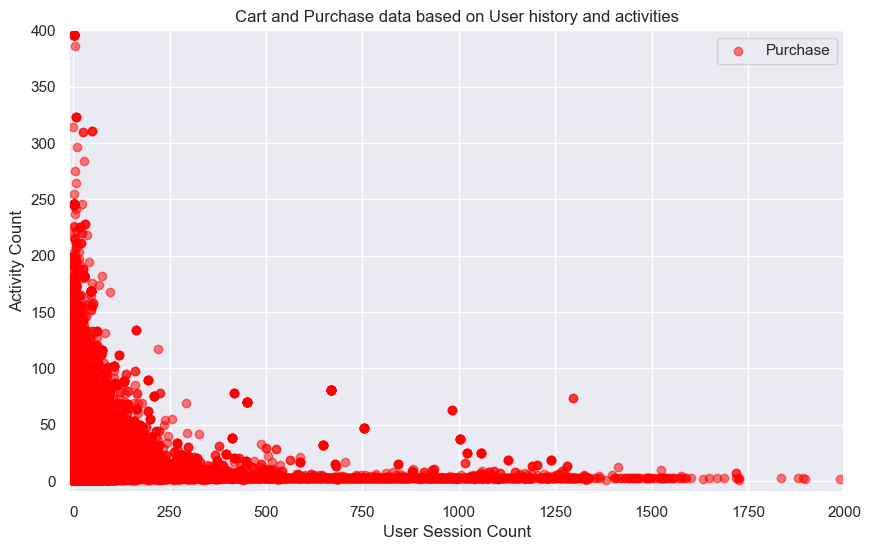

In [22]:
#Supplementary: Individual Scatter Plot
plt.figure(figsize=(10, 6))

# Scatter plot for purchase
plt.scatter(df[df['event_type'] == 2]['user_session_count'], df[df['event_type'] == 2]['activity_count'],
            color='red', alpha=0.5, label='Purchase')
# Adding labels and title
plt.xlabel('User Session Count')
plt.ylabel('Activity Count')
plt.title('Cart and Purchase data based on User history and activities')

plt.xlim(-10, 2000)  # Limiting x-axis from 0 to 10
plt.ylim(-10, 400)  # Limiting y-axis from 0 to 1000
# Adding legend
plt.legend()

plt.grid(True)
plt.show()

#### D. Price and Brand of Product

In [23]:
# Grouping the data by 'brand' and 'event_type', then counting the occurrences
brand_activity_count = df.groupby(['brand', 'event_type']).size().unstack(fill_value=0)

# Adding a column for total interactions
brand_activity_count['total_interactions'] = brand_activity_count.sum(axis=1)

# Calculating the percentage of purchases
brand_activity_count['purchase_percentage'] = (brand_activity_count[2] / brand_activity_count['total_interactions']) * 100
brand_activity_count.sort_values(by='total_interactions',ascending=False, inplace=True)
print(brand_activity_count.to_markdown())

| brand                          |      1 |      2 |   total_interactions |   purchase_percentage |
|:-------------------------------|-------:|-------:|---------------------:|----------------------:|
| samsung                        | 390034 | 431728 |               821762 |             52.5369   |
| apple                          | 346825 | 346908 |               693733 |             50.006    |
| xiaomi                         | 232903 | 163928 |               396831 |             41.3093   |
| huawei                         |  71004 |  72352 |               143356 |             50.4702   |
| lucente                        |  28138 |  34161 |                62299 |             54.8339   |
| sony                           |  33461 |  24809 |                58270 |             42.5759   |
| oppo                           |  23906 |  29866 |                53772 |             55.5419   |
| lg                             |  29227 |  23918 |                53145 |             45.0052   |


In [24]:
print(f'The standard deviation for purchase percentage of a brand is {brand_activity_count["purchase_percentage"].std()} %.')

The standard deviation for purchase percentage of a brand is 21.611466192909038 %.


Hence, since there is such a high standard deviation, the brand seems to have an effect on whether the user will purchase eventually. Thus, **brand is a good predictor for our model.**

In [25]:
# Manafe memory by deleting unecessary dataframes
del brand_activity_count

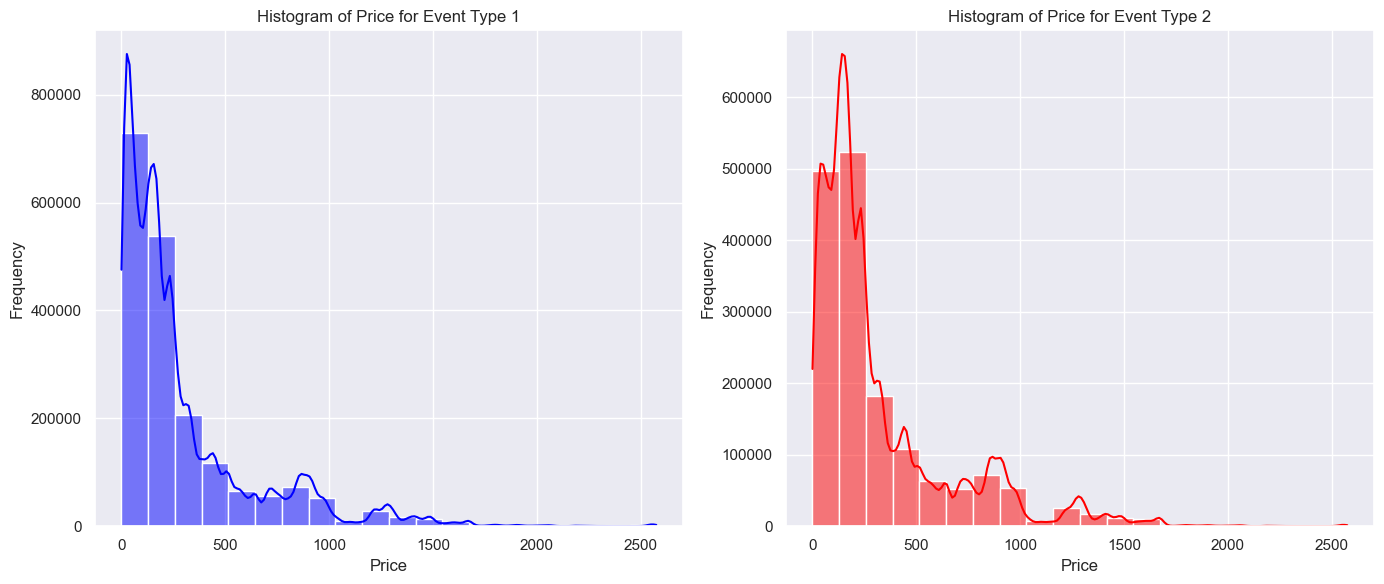

In [26]:
plt.figure(figsize=(14, 6))

# Create a subplot for the first histogram
plt.subplot(1, 2, 1)
sb.histplot(df[df['event_type'] == 1]['price'], bins=20, color='blue', kde=True)
plt.title('Histogram of Price for Event Type 1')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Create a subplot for the second histogram
plt.subplot(1, 2, 2)
sb.histplot(df[df['event_type'] == 2]['price'], bins=20, color='red', kde=True)
plt.title('Histogram of Price for Event Type 2')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From the histogram and KDE, it appears that a moderate price range (second bar) is morelikely to be purchased than those in other category. Hence, **price is a good predictor for our model.**

Text(0, 0.5, 'Price')

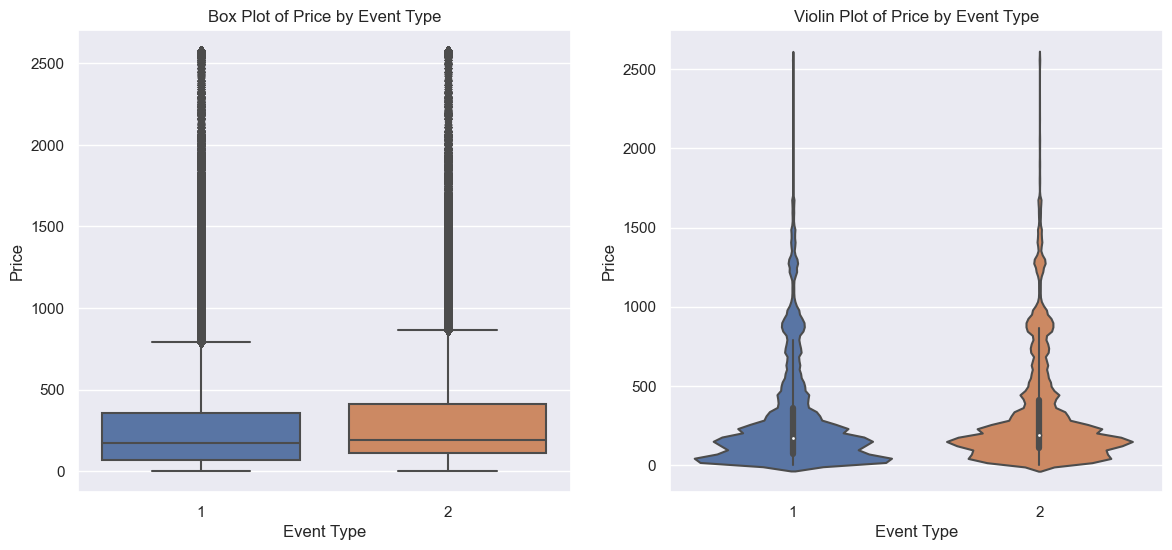

In [27]:
plt.figure(figsize=(14, 6))

# Creating subplots for box plots
plt.subplot(1, 2, 1)
sb.boxplot(x='event_type', y='price', data=df)
plt.title('Box Plot of Price by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Price')

# Creating subplots for violin plots
plt.subplot(1, 2, 2)
sb.violinplot(x='event_type', y='price', data=df)
plt.title('Violin Plot of Price by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Price')



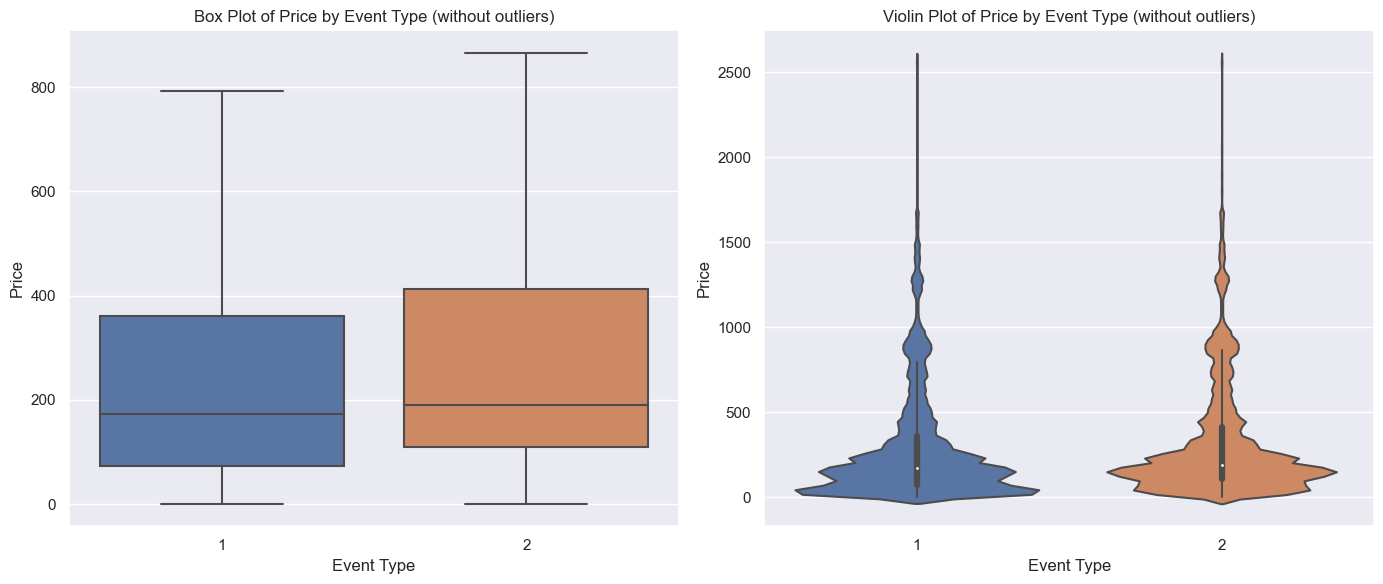

In [28]:
plt.figure(figsize=(14, 6))

# Creating subplots for box plots without ouliers
plt.subplot(1, 2, 1)
sb.boxplot(x='event_type', y='price', data=df,showfliers=False)
plt.title('Box Plot of Price by Event Type (without outliers)')
plt.xlabel('Event Type')
plt.ylabel('Price')
# Creating subplots for violin plots without outliers
plt.subplot(1, 2, 2)
sb.violinplot(x='event_type', y='price', data=df, showfliers=False)
plt.title('Violin Plot of Price by Event Type (without outliers)')
plt.xlabel('Event Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

This decision is also supported by our boxplot where a slightly higher price will be more likely to be purchased than a lower price as shown

### Export Train Data to Build our model

In [29]:
#One final check of our data format
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


In [30]:
df.to_csv('TrainData.csv.gz', index = False, compression = 'gzip')